# Загрузка необходимых библиотек

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import tensorflow as tf
import zipfile
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# прописываем путь к архиву
zip_file = '/content/drive/MyDrive/DS_identity_emotions/input_data/redact_clean.zip'

# распакуем архив
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()

In [ ]:
# определим папки с данными, теперь итоговые изображения находятся в папке redact
train_dir = Path().parent / "redact"

train_anger_dir = train_dir / 'anger'
train_contempt_dir = train_dir / 'contempt'
train_disgust_dir = train_dir / 'disgust'
train_fear_dir = train_dir / 'fear'
train_happy_dir = train_dir / 'happy'
train_neutral_dir = train_dir / 'neutral'
train_sad_dir = train_dir / 'sad'
train_surprise_dir = train_dir / 'surprise'
train_uncertain_dir = train_dir / 'uncertain'

In [ ]:
def show_catsdogs(images, labels, predicted_labels=None, row=False, title=""):
    '''Функция для отображения изображений'''
    names = {0: "anger", 1: "contempt", 2: "disgust", 3: "fear", 4: "happy", 
             5: "neutral", 6: "sad", 7: "surprise", 8: "uncertain"}
    fig = plt.figure(figsize=(10, 3 if row else 10))
    st = fig.suptitle(title, fontsize="x-large")
    n = 5 if row else 16
    for i in range(n):
        if not row:
            plt.subplot(4,4, i+1)
        else:
            plt.subplot(1,5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.gray)
        if predicted_labels is not None:
            title_obj = plt.title(f"Real: {names[np.argmax(labels[i])]}. Pred: {names[predicted_labels[i]]}")
            if labels[i] != predicted_labels[i]:
                plt.setp(title_obj, color='r')
        else:
            plt.title(f"Real label: {names[np.argmax(labels[i])]}")

#ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Подготовка входных данных

In [ ]:
BATCH_SIZE = 128

In [ ]:
image_gen_no_aug = ImageDataGenerator(rescale=1./255, validation_split=0.2)
sample_no_aug = image_gen_no_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(128,128),
                                                     class_mode='categorical',
                                                     subset = "training",
                                                     seed=123
                                                     )

Found 38569 images belonging to 9 classes.


In [ ]:
# а теперь мы попросим его изменять изображение на лету, добавляя небольшие повороты + отражения по горизонтали
image_gen_aug = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,  # максимальный угол поворота
    horizontal_flip=True, # случайное отражение по горизонтали
    fill_mode="nearest", # чем заполнять пробелы
    validation_split=0.2  # соотношение тренировочных/валидационных данных = 0.8/0.2
    ) 



train_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                   directory=train_dir,
                                                   shuffle=True,
                                                   target_size=(128,128),
                                                   class_mode='categorical',
                                                   subset = "training",
                                                   seed = 123)  # 80%

val_data_gen = image_gen_aug.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=train_dir,
                                                 shuffle=False,
                                                 target_size=(128,128),
                                                 class_mode='categorical',
                                                 subset = "validation",
                                                 seed = 123)  # 20%


Found 38569 images belonging to 9 classes.
Found 9639 images belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


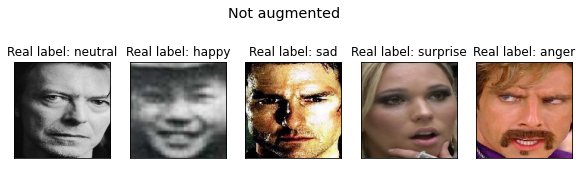

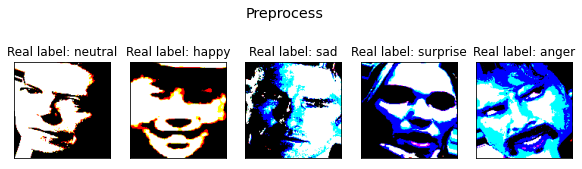

In [ ]:
sample_images, sample_labels = next(sample_no_aug)
show_catsdogs(sample_images, sample_labels, row=True, title="Not augmented")
sample_images, sample_labels = next(train_data_gen)
show_catsdogs(sample_images, sample_labels, row=True, title="Preprocess")

##Загрузка архитектуры модели, инициализируем веса обученные на датасете ImageNet

In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- ResNet50
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')
base_model.trainable = False # замораживаем всю базовую модель
base_model.summary()

94781440/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalizat

Попробуем сначала взять архитектуру исходную, не изменяя веса. В конце сети добавим Dense слой на 9 нейронов - кол-во классов, обучим его и посмотрим графически точность на валидационной и тестовой выборке.

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')  # 9 - кол-во классов
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


###Замерим время инференса

In [ ]:
sample_images, sample_labels = next(val_data_gen)
test_img = sample_images[0][None,...]
test_img.shape

(1, 128, 128, 3)

In [ ]:
%%time

predictions = model.predict(test_img)

CPU times: user 59.6 ms, sys: 651 µs, total: 60.3 ms
Wall time: 68 ms


In [ ]:
%%timeit -n 10 -r 10

predictions = model.predict(test_img)

10 loops, best of 10: 51.9 ms per loop


##Время инференса удовлетворяет условию задачи, дальше приступим к обучению модели и тестированию

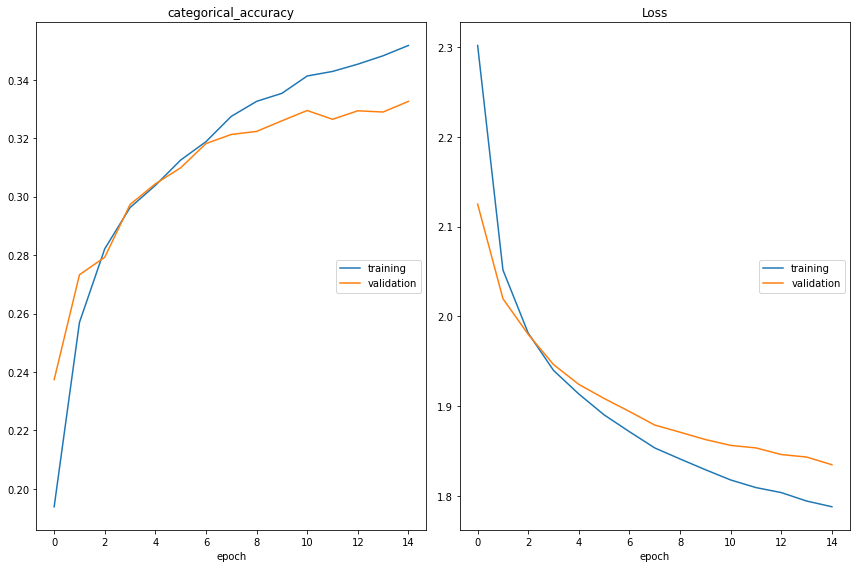

categorical_accuracy
	training         	 (min:    0.194, max:    0.352, cur:    0.352)
	validation       	 (min:    0.237, max:    0.333, cur:    0.333)
Loss
	training         	 (min:    1.788, max:    2.302, cur:    1.788)
	validation       	 (min:    1.835, max:    2.125, cur:    1.835)
302/302 [==============================] - 422s 1s/step - loss: 1.7880 - categorical_accuracy: 0.3518 - val_loss: 1.8348 - val_categorical_accuracy: 0.3326


In [ ]:
EPOCHS = 15
history = model.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
model.save('./model_ResNet50/1')

In [ ]:
model.save('/content/drive/MyDrive/DS_identity_emotions/model/ResNet50_one_dense')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_one_dense/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DS_identity_emotions/model/vgg19_one_dense/assets


In [ ]:
!zip -r model_ResNet50.zip model_ResNet50

Разморозим все веса и обучим всю архитектуру.

In [ ]:
IMG_SHAPE = (128, 128, 3)
# базовая модель -- ResNet50
all_base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
all_base_model.trainable = True # размораживаем всю базовую модель

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model_all = tf.keras.Sequential([
  all_base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(9, activation='softmax')  # 9 - кол-во классов
])

model_all.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

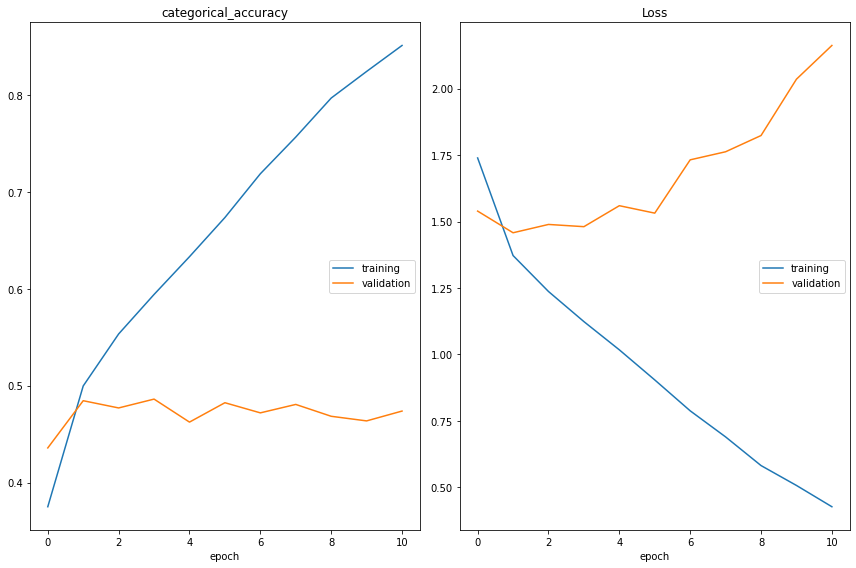

categorical_accuracy
	training         	 (min:    0.375, max:    0.851, cur:    0.851)
	validation       	 (min:    0.436, max:    0.486, cur:    0.474)
Loss
	training         	 (min:    0.427, max:    1.739, cur:    0.427)
	validation       	 (min:    1.458, max:    2.162, cur:    2.162)
302/302 [==============================] - 407s 1s/step - loss: 0.4274 - categorical_accuracy: 0.8514 - val_loss: 2.1620 - val_categorical_accuracy: 0.4738
Epoch 12/15
171/302 [===============>..............] - ETA: 2:24 - loss: 0.3437 - categorical_accuracy: 0.8852

In [ ]:
EPOCHS = 15
history_all = model_all.fit_generator(
    train_data_gen,
    epochs=EPOCHS,
    validation_data=val_data_gen,
    callbacks=[PlotLossesCallback()])

In [ ]:
model.save('/content/drive/MyDrive/DS_identity_emotions/model/ResNet50_all')

#Вывод:</br>
Аналогично процессу обучения MobileNetV2 и VGG19:</br>*Использовались изображения обрезанные по Bounding box.</br>
С целью расширения вариативности входных данных - была проведена аугментация. Увеличивать, уменьшать и сдвигать изображения - не имеет смысла, т.к. они обрезаны по границе лица. В качестве вариации было задано: поворот - не более чем на 20 градусов и отражение по горизонтали.*</br></br>
В итоге, самые лучшие результаты показала модель: **VGG19**!</br>
**ResNet50** также показала лучший результат при обучении всех весов, но 11 эпох достаточно, чтобы понять - на валидации точность не растет.</br>
Максимально достигнутая точность на валидационных данных: 0.486.</br>
Среднее время инференса: 51.9 мс.</br>
Дальше попробуем до обучить модель **VGG19** и ускорим процесс инференса.